# Operação Rodes

## Configurações do ambiente

In [1]:
import os
import sys
from datetime import datetime
from IPython.display import HTML

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import pymysql
import pandas as pd

WIDTH = 1100
pd.options.display.float_format = 'R$ {:,.2f}'.format

caminho_commons = os.path.join('../..', '..', 'ajna_docs', 'commons')
caminho_virasana = os.path.join('../..', '..', 'ajna_docs', 'virasana')
sys.path.append(caminho_commons)
sys.path.append('../..')
sys.path.append(caminho_virasana)

from bhadrasana.models import engine


def AnoMes(row):
    return str(row.Ano) + str(row['Mês']).zfill(2)


# Definindo a URL de conexão diretamente
connection_details = {
        'host': '10.61.8.28',
        'port': 3306, 
        'user': 'admmerc',       
        'password': 'Adm_DBM3rc',     
        'db': 'dbmercante'  
}


2025-06-17 14:48:52,588 ajna         INFO     Configuração de log efetuada


Fazendo log de erros e alertas no arquivo  C:\Users\11913225640\git\bhadrasana2\notebooks\gerenciais\../..\..\ajna_docs\commons\ajna_commons\flask\error.log
Fazendo log de atividade no arquivo  C:\Users\11913225640\git\bhadrasana2\notebooks\gerenciais\../..\..\ajna_docs\commons\ajna_commons\flask\access.log


## Visão Geral por Recinto

In [2]:
# Query SQL para buscar os dados
SQL_Rodes = '''
     SELECT 
         r.nome as Recinto, 
         ficha.id as 'Ficha', 
         rvf.id as 'RVF', 
         rvf.datahora 'Data de Abertura',
         ficha.numeroCEmercante, 
         rvf.numerolote as Conteiner, 
         ficha.fase,
         flags.flag_id,
        c.PortoDestFinal as PortoDestino
     FROM ovr_ovrs ficha
     INNER JOIN ovr_verificacoesfisicas rvf ON  rvf.ovr_id = ficha.id
     INNER JOIN ovr_recintos r ON r.id = ficha.recinto_id
     INNER join ovr_flags_ovr flags on flags.rvf_id = ficha.id
     LEFT join conhecimentosresumo c on c.numeroCEmercante = ficha.numeroCEmercante
     where flags.flag_id = 2472
     ORDER BY r.nome, rvf.datahora
'''

# Usando o contexto de conexão para garantir o uso correto da conexão
try:
    # Estabelecendo a conexão com o banco de dados
    connection = pymysql.connect(**connection_details)

    # Executa a query e carrega o resultado em um DataFrame
    df_Rodes = pd.read_sql(SQL_Rodes, connection)

    # Obtendo a data atual
    today_ = datetime.today()

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_Rodes.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")


C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\220437587.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Rodes = pd.read_sql(SQL_Rodes, connection)


,Recinto,Ficha,RVF,Data de Abertura,numeroCEmercante,Conteiner,fase,flag_id,PortoDestino
0,BANDEIRANTES DEICMAR - IPA OUTEIRINHOS,11600,10413,2025-03-18 09:29:00,152505065965204,FSCU9318964,1,2472,BRSSZ
1,BANDEIRANTES DEICMAR - IPA OUTEIRINHOS,11739,10566,2025-04-07 09:30:00,152505007538021,CAIU9227039,2,2472,BRSSZ
2,BANDEIRANTES DEICMAR - IPA OUTEIRINHOS,11600,10804,2025-05-27 10:35:00,152505065965204,FSCU9318964,1,2472,BRSSZ
3,EMBRAPORT - EMPRESA BRASILEIRA DE TERMINAIS PO...,11602,10405,2025-03-17 09:30:00,152505052898295,CAAU6887437,2,2472,BRSSZ
4,EMBRAPORT - EMPRESA BRASILEIRA DE TERMINAIS PO...,11598,10420,2025-03-20 13:35:00,152505036060886,,4,2472,BRSSZ


## Conteiner por Ficha

In [4]:
SQL_TGs = \
    '''SELECT year(tg.create_date) AS Ano, ovr.id AS Ficha,
         rvf.numerolote as Conteiner
       FROM ovr_ovrs ovr
       inner join ovr_verificacoesfisicas rvf on rvf.ovr_id = ovr.id
       INNER JOIN ovr_tgovr tg ON ovr.id = tg.ovr_id
       INNER JOIN ovr_flags_ovr flags ON flags.rvf_id = ovr.id
       WHERE ovr.setor_id IN (1, 2)
       AND flags.flag_id = 2472;'''

try:

    # Executa a query e carrega o resultado em um DataFrame
    df_tgs = pd.read_sql(SQL_TGs, connection)

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_tgs.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\3756823540.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tgs = pd.read_sql(SQL_TGs, connection)


,Ano,Ficha,Conteiner
0,2025,11600,FSCU9318964
1,2025,11600,FSCU9318964


## Visão consolidada TG

In [7]:

SQL_TGs_SUM = \
    '''SELECT year(tg.create_date) AS Ano, month(tg.create_date) AS Mês, 
              COUNT(tg.id) AS Qtde, SUM(tg.valor) AS ValorTG, rvf.numerolote as Conteiner
       FROM ovr_ovrs ovr
       inner join ovr_verificacoesfisicas rvf on rvf.ovr_id = ovr.id
       INNER JOIN ovr_tgovr tg ON ovr.id = tg.ovr_id
       INNER JOIN ovr_flags_ovr flags ON flags.rvf_id = ovr.id 
       WHERE ovr.setor_id IN (1, 2)
       AND flags.flag_id = 2472
       GROUP BY year(tg.create_date), month(tg.create_date);'''

try:
    # Executa a query e carrega o resultado em um DataFrame
    df_tgs_sum = pd.read_sql(SQL_TGs_SUM, connection)

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_tgs_sum.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\3515672896.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tgs_sum = pd.read_sql(SQL_TGs_SUM, connection)


,Ano,Mês,Qtde,ValorTG,Conteiner
0,2025,5,2,"R$ 5,265,225.00",FSCU9318964


## Total Containeres, TGs e Valor parcial perdimento

In [9]:
SQL_TGs_RODES = \
    '''SELECT year(tg.create_date) as Ano, month(tg.create_date) as Mês, ovr.id as Ficha,
      tg.id as TG, tg.valor as ValorTG, rvf.numerolote as Conteiner
      FROM ovr_ovrs ovr
      inner join ovr_verificacoesfisicas rvf on rvf.ovr_id = ovr.id
     inner join ovr_tgovr tg on ovr.id = tg.ovr_id
     inner join ovr_flags_ovr flags on flags.rvf_id = ovr.id
     where flags.flag_id = 2472 and tg.valor > 2000
     order by Ano, Mês;'''


# Executa a query e carrega o resultado em um DataFrame
df_Rodes_apreensoes = pd.read_sql(SQL_TGs_RODES, connection)

# Agrupando por ano e calculando a contagem de TGs e a soma de ValorTG
resultados = df_Rodes_apreensoes.groupby('Ano').agg(
    Total_Conteiner=('Conteiner', 'count'), #>> 1.1 Qual o total de contêineres retidos?  
    Total_TGs=('TG', 'nunique'),
    Total_ValorTG=('ValorTG', 'sum') #>> 1.3 Valor parcial dos perdimentos? 
).reset_index()

# Imprimindo os resultados
for index, row in resultados.iterrows():
    print(f"Ano: {row['Ano']}, Conteiner: {row['Total_Conteiner']}, Total de TGs: {row['Total_TGs']}, Total ValorTG: {row['Total_ValorTG']}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\1921432395.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_Rodes_apreensoes = pd.read_sql(SQL_TGs_RODES, connection)


Ano: 2025.0, Conteiner: 2.0, Total de TGs: 1.0, Total ValorTG: 5265225.0


##  Andamento dos saneamentos

26 Fichas de controle no total, com os seguintes status:


C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\1315491290.py:22: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



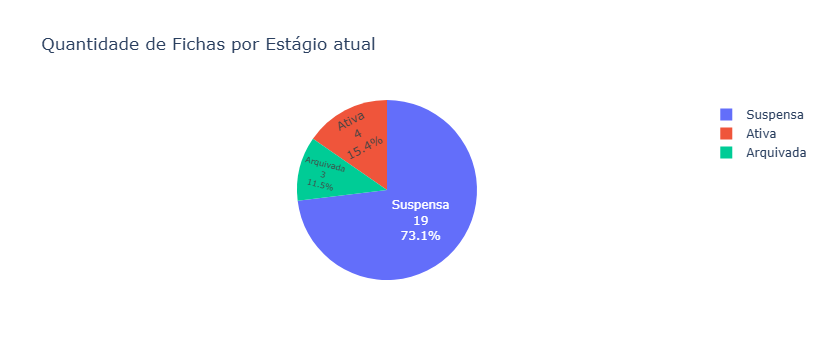

In [12]:

def AnoMes(row):
    return f"{int(row['Ano'])}-{int(row['Mês']):02d}"


SQL_Fichas_Rodes_Tempos = '''
    SELECT year(ficha.create_date) as Ano, month(ficha.create_date) as Mês, r.nome as Recinto, e.fase as Estágio,
           ficha.id as Ficha, rvf.numerolote as Conteiner, ficha.create_date as create_date, 
           min(ev.create_date) as data_evento_inicial, max(ev.create_date) as data_evento_ultimo
    FROM ovr_ovrs ficha
    INNER JOIN ovr_verificacoesfisicas rvf ON rvf.ovr_id = ficha.id 
    INNER JOIN ovr_eventos ev ON ev.ovr_id = ficha.id
    INNER JOIN ovr_flags_ovr flags ON flags.rvf_id = ficha.id
    INNER JOIN Enumerado e ON e.id = ficha.fase
    INNER JOIN ovr_recintos r ON r.id = ficha.recinto_id
    WHERE flags.flag_id = 2472
    GROUP BY year(ficha.create_date), month(ficha.create_date), r.nome, e.fase, ficha.id, rvf.numerolote, ficha.create_date
    ORDER BY create_date ASC;
'''

# Executa e processa
df_fichas_tempos = pd.read_sql(SQL_Fichas_Rodes_Tempos, connection)


df_fichas_tempos['create_date'] = pd.to_datetime(df_fichas_tempos['create_date'])
df_fichas_tempos['data_evento_ultimo'] = pd.to_datetime(df_fichas_tempos['data_evento_ultimo'])

df_fichas_tempos['Duracao'] = (df_fichas_tempos['data_evento_ultimo'] - df_fichas_tempos['create_date']).dt.days
df_fichas_tempos['AnoMes'] = df_fichas_tempos.apply(AnoMes, axis=1)

# Função de visualização
def FigFichasTempoTotal(df_=df_fichas_tempos):
    df_fichas_estagio = df_.groupby(['AnoMes', 'Estágio']).Ficha.count().reset_index()
    print(f'{df_fichas_estagio.Ficha.sum()} Fichas de controle no total, com os seguintes status:')
    fig = px.pie(df_fichas_estagio, names='Estágio', values='Ficha',
                 title='Quantidade de Fichas por Estágio atual')
    fig.update_traces(textposition='inside', textinfo='percent+label+value')
    fig.update_layout(width=WIDTH)
    fig.show()


FigFichasTempoTotal()


## NCM por Container

In [15]:
SQL_NCMs_conteiner = \
    '''SELECT year(tg.create_date) as Ano,  substring(i.ncm, 1, 4) as NCM,
    count(i.id) as Qtde, sum(i.valor * i.qtde) as Valor, rvf.numerolote as Conteiner
      FROM ovr_ovrs ovr
     inner join ovr_verificacoesfisicas rvf on rvf.ovr_id = ovr.id
     inner join ovr_tgovr tg on ovr.id = tg.ovr_id
     inner join ovr_itenstg i on i.tg_id = tg.id
     inner join ovr_flags_ovr flags on flags.rvf_id = ovr.id
     where ovr.setor_id in (1, 2) AND flags.flag_id = 2472 and i.ncm is not null
     group by year(tg.create_date), substring(i.ncm, 1, 4)
     order by Ano, Valor desc;'''


try:

    # Executa a query e carrega o resultado em um DataFrame
    df_ncm_cont_Rodes = pd.read_sql(SQL_NCMs_conteiner, connection)

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_ncm_cont_Rodes.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\1642969880.py:17: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,Ano,NCM,Qtde,Valor,Conteiner
0,2025,8517,24,"R$ 1,851,610.00",FSCU9318964
1,2025,8518,36,"R$ 896,640.00",FSCU9318964
2,2025,8471,6,"R$ 391,600.00",FSCU9318964
3,2025,9027,2,"R$ 240,000.00",FSCU9318964
4,2025,9001,8,"R$ 226,200.00",FSCU9318964


## Agrupamento por NCM

In [13]:
SQL_NCMs = \
    '''SELECT
      SUBSTR(i.ncm, 1, 4)      AS ncm4,           -- primeiros 4 dígitos de NCM
      i.descricao			   AS descricao,
      SUM(i.qtde)              AS total_qtde, 
      SUM(i.qtde * i.valor)    AS total_valor   
    FROM
      ovr_flags_ovr AS fo
      INNER JOIN ovr_ovrs      AS o  ON fo.rvf_id = o.id
      INNER JOIN ovr_tgovr     AS tg ON tg.ovr_id = o.id
      INNER JOIN ovr_itenstg   AS i  ON i.tg_id = tg.id
    WHERE
      fo.flag_id = 2472
    GROUP BY
      SUBSTR(i.ncm, 1, 4),  
      i.unidadedemedida   
    ORDER BY
      total_qtde DESC;  '''


try:

    # Executa a query e carrega o resultado em um DataFrame
    df_ncm_Rodes = pd.read_sql(SQL_NCMs, connection)

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_ncm_Rodes.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\326783357.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,ncm4,descricao,total_qtde,total_valor
0,9001,LENTES DE CONTATO - MARCA: EYE SHARE - MODELO:...,"R$ 19,640.00","R$ 113,100.00"
1,8517,RELOGIO SMARTWATCH - MARCA: BENEDO - MODELO: B...,"R$ 12,473.00","R$ 925,805.00"
2,9113,PULSEIRA PARA SMATWATCH - MARCA: S/M - MODELO:...,"R$ 8,790.00","R$ 70,880.00"
3,8518,MICROFONE PROFISSIONAL WIRELESS - MARCA: UHF -...,"R$ 4,588.00","R$ 448,320.00"
4,3919,CAPA DE PROTEÇÃO SMARTWATCH - MARCA: WATCH ULT...,"R$ 2,500.00","R$ 10,500.00"


## Apreensões

In [16]:
SQL_APREENSOES = \
    '''
    SELECT year(rvf.datahora) as Ano, month(rvf.datahora) as Mês, rvf.datahora,
      r.nome as recinto,
      ovr.id as Ficha, rvf.id as RVF, rvf.descricao as relato, rvf.numerolote as Conteiner,
      a.id as Apreensao, a.descricao, t.descricao, a.peso as Peso, c.PortoDestFinal as PortoDestino,flags.flag_id
      FROM ovr_ovrs ovr
     inner join ovr_verificacoesfisicas rvf on rvf.ovr_id = ovr.id
     inner join ovr_apreensoes_rvf a on a.rvf_id = rvf.id
     inner join ovr_tiposapreensao t on t.id = a.tipo_id
     inner join ovr_recintos r on r.id = ovr.recinto_id
     inner join ovr_flags_ovr flags on flags.rvf_id = ovr.id
     left join conhecimentosresumo c on c.numeroCEmercante = ovr.numeroCEmercante
     where flags.flag_id = 2472
     order by Ano, Mês, Ficha, RVF, Apreensao;'''

try:

    # Executa a query e carrega o resultado em um DataFrame
    df_apreensoes = pd.read_sql(SQL_APREENSOES, connection)

    # Exibindo os primeiros registros do DataFrame como exemplo
    display(df_apreensoes.head())

except Exception as e:
    print(f"Erro ao conectar ou executar a query: {e}")

C:\Users\11913225640\AppData\Local\Temp\ipykernel_10952\1354656378.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,Ano,Mês,datahora,recinto,Ficha,RVF,relato,Conteiner,Apreensao,descricao,descricao,Peso,PortoDestino,flag_id
